# Final Project Code

This notebook contains our final project code for CS M148. The dataset we used was the DoorDash Delivery Dataset, which includes operational and behavioral features related to delivery performance.

Our goal is to use operational DoorDash data to predict whether an order will be abnormally slow. This could help DoorDash improve ETA accuracy, help allocate dashers more efficiently, and reduce customer complaints.

The notebook contains package installations/imports, EDA, data visualizations, data preprocessing/cleaning, feature engineering, and then a Random Forest Classifier fit on this data to predict whether an order will be "slow". This Random Forest model is trained, fit, optimized, and then evaluated using a variety of metrics and methods.

# Prolog

In [ ]:
# !pip install sklego # install if necessary

In [ ]:
# all necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.impute import SimpleImputer
from google.colab import files

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, f1_score, accuracy_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline

In [ ]:
pd.set_option('display.max_columns', None)

# Exploratory Data Analysis

For this part in the project, we will look to step 2 in the Data Science Life Cycle, focusing on creating insights from the data based on graphs, charts, etc. This can help us with data preprocessing and model building later down the road.


In [ ]:
# using original Doordash data linked from our GitHub

url = "https://github.com/rtleong/CSM148_DoorDash_Project_Fall25/raw/main/historical_data.csv"

df = pd.read_csv(url)
df.sample(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
42045,1.0,2015-02-07 01:29:21,2015-02-07 02:13:48,6567,mexican,5.0,3,2200,3,600,800,35.0,35.0,42.0,251,301.0
26329,2.0,2015-01-28 05:46:17,2015-01-28 06:24:51,6281,dessert,1.0,2,1590,2,795,795,8.0,7.0,8.0,446,654.0
54159,6.0,2015-02-03 21:15:02,2015-02-03 21:55:19,973,burmese,1.0,3,2975,3,325,1350,NaN,NaN,NaN,446,722.0
176988,4.0,2015-01-31 03:56:43,2015-01-31 04:50:02,791,NaN,1.0,2,1698,2,499,1199,88.0,88.0,156.0,446,379.0
35183,2.0,2015-01-21 19:49:06,2015-01-21 20:35:22,65,indian,1.0,2,2494,2,1195,1299,36.0,36.0,54.0,446,295.0


In [ ]:
df.shape

(197428, 16)

In [ ]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')

In [ ]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

We can see that the variables created_at, actual_delivery_time should be datetime objects. As such, we convert them here

In [ ]:
#convert columns to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

print(df['actual_delivery_time'].dtype)
print(df['created_at'].dtype)

datetime64[ns]
datetime64[ns]


We need to create some data features that are explained in the data preprocessing section. These include converting columns to datetime, extracting information like the hour of delivery or how long it takes in total, and more.

In [ ]:
# add column for delivery duration
df['delivery_duration_min'] = ((df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60).round(2)

#hour of order creation and order delivery
df['created_hour'] = df['created_at'].dt.hour
df['delivered_hour'] = df['actual_delivery_time'].dt.hour


# for the point of eda, we can get rid of atrociously high values that skew the visualizations too much
df_copy = df[df['delivery_duration_min'] < 400].copy()

Here, we can visualize the amount of missingness in each column of the dataset. This can help with identifying which columns need the most attention for NA treatment, whether that just be removing them if there is such a minute amount or doing more serious imputation.

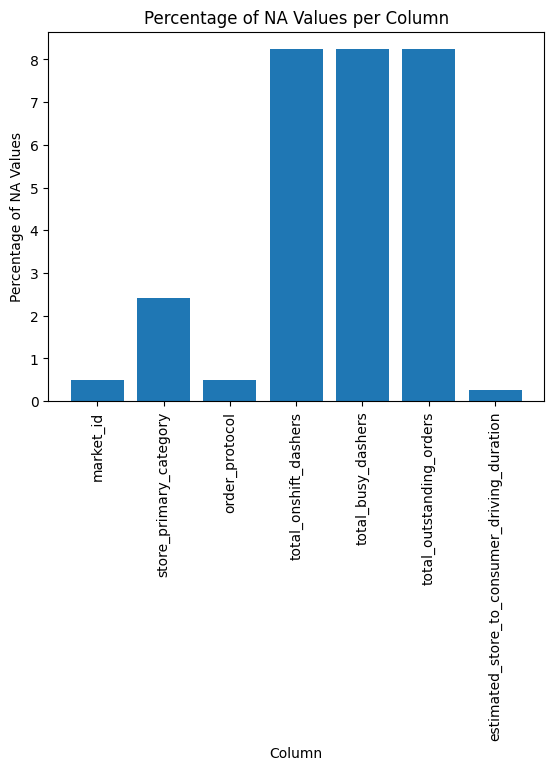

In [ ]:
# we can see the % missing per column here
na_percent = df_copy.isna().sum() / df_copy.shape[0] * 100

plt.bar(df_copy.columns[na_percent > 0], (na_percent)[na_percent > 0])
plt.xlabel('Column')
plt.ylabel('Percentage of NA Values')
plt.title('Percentage of NA Values per Column')
plt.xticks(rotation=90)
plt.show()

As we can see, there are only a few columns that actually have NAs, which is helpful in our data science process. Even more, there are only 3 categories that have 8% NAs, while the next one has less than 3% NAs. This means that we should look to impute NAs for these columns, while the rest can be looked at on a case-to-case basis depending on its use for the model and what it represents.

We can move on to looking at relationships between the columns:

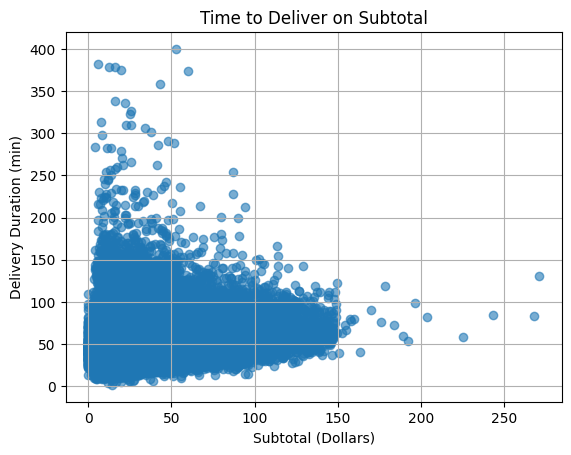

In [ ]:
# scatterplot for delivery duration on subtotal
plt.scatter(df_copy['subtotal']/100, df_copy['delivery_duration_min'], alpha=0.6)
plt.title('Time to Deliver on Subtotal')
plt.xlabel('Subtotal (Dollars)')
plt.ylabel('Delivery Duration (min)')
plt.grid(True)
plt.show()

We saw earlier that there are some gross outliers, including an order that took over 140,000 minutes to deliver. This is quite obviously incorrect, so by making the scale more reasonable, we can get a better fit of the data for delivery duration with respect to subtotal. We have since removed these extreme values for the point of data visualization, however come time for actual preprocessing we chose a more methodical way of removing these extremes (this is just for looks purposes).

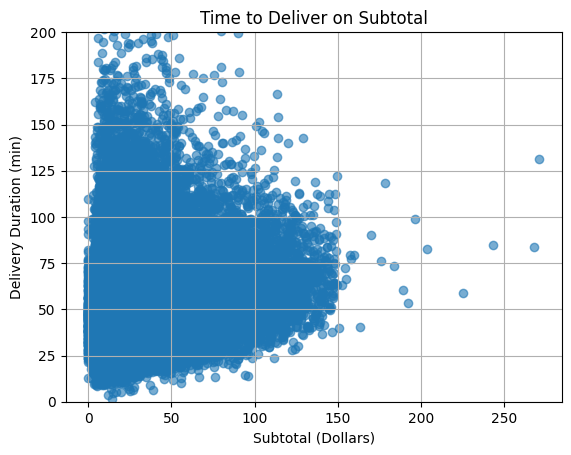

In [ ]:
# scatterplot for delivery duration on subtotal with better scale
plt.scatter(df_copy['subtotal']/100, df_copy['delivery_duration_min'], alpha=0.6)
plt.title('Time to Deliver on Subtotal')
plt.xlabel('Subtotal (Dollars)')
plt.ylabel('Delivery Duration (min)')
plt.ylim(0,200)
plt.grid(True)
plt.show()

With this, we can see that although the ranges are extremely large for majority of the dollar amounts, as the subtotal increases, the minimum delivery duration similarly increases. Also, the maximum decreases, and it appears that the data is converging at a point in which the min and max delivery duration meet. However, this is probably due to the fact that there are significantly more orders at lower price points, so the variability with how long it takes drivers to get there is higher.

Next, we can examine the amount of orders during various periods of time.

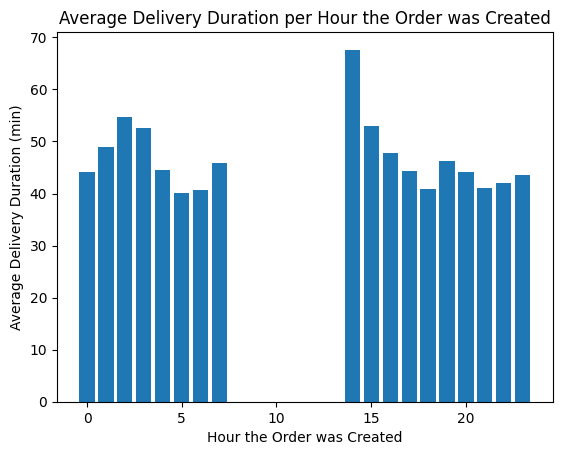

In [ ]:
# avg delivery duration min per hour
mean_by_hour = df_copy.groupby('created_hour')['delivery_duration_min'].mean().reset_index()
plt.bar(mean_by_hour['created_hour'], mean_by_hour['delivery_duration_min'])
plt.xlabel('Hour the Order was Created')
plt.ylabel('Average Delivery Duration (min)')
plt.title('Average Delivery Duration per Hour the Order was Created')
plt.show()

As seen above, there appears to be a gap in the data in which it does not register orders from 8am until 1pm (the graph is in military time). This is important to take into account as we do our analysis, as brunch and lunch times are extremely popular for ordering food, so this could impact our results. Even more, we see a peak at 2pm, right after the missing data, which could also be somewhat of a fluke or data source error. Other than that, it appears that the average time for delivery takes about 40-50 minutes regardless of what hour of the day one orders.

Continuing, we can examine how the number of items in the order could affect the time of delivery.

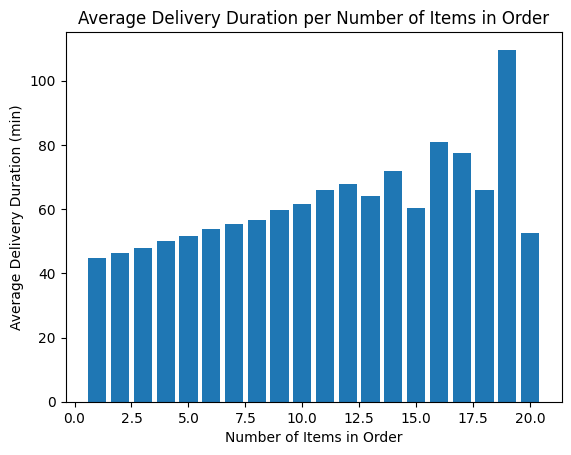

In [ ]:
# avg delivery duration min per item count
mean_by_item_count = df_copy.groupby('num_distinct_items')['delivery_duration_min'].mean().reset_index()
plt.bar(mean_by_item_count['num_distinct_items'], mean_by_item_count['delivery_duration_min'])
plt.xlabel('Number of Items in Order')
plt.ylabel('Average Delivery Duration (min)')
plt.title('Average Delivery Duration per Number of Items in Order')
plt.show()

As we can see, there is a definite and constant increase in the amount of time it takes to deliver an order based off of the number of items in said order. This is a consistent and linear increase, however as the number of items hits 15+, there is more variability, including an extremely high average time for orders with 19 items. This could be due to just not a lot of orders having that many and only a couple of outliers could pull it up.

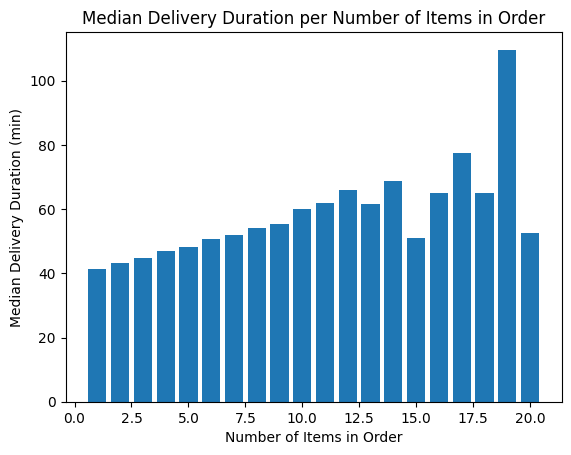

In [ ]:
# median delivery duration min per item count
median_by_item_count = df_copy.groupby('num_distinct_items')['delivery_duration_min'].median().reset_index()
plt.bar(median_by_item_count['num_distinct_items'], median_by_item_count['delivery_duration_min'])
plt.xlabel('Number of Items in Order')
plt.ylabel('Median Delivery Duration (min)')
plt.title('Median Delivery Duration per Number of Items in Order')
plt.show()

After plotting the median instead of the mean, we can still see this higher variability and randomness as the number of orders increase, indicating that this is most likely an issue of sample size.

Finally, we can examine a distribution of the variable, delivery_duration_min, which will be the focal point of our predictions and models.

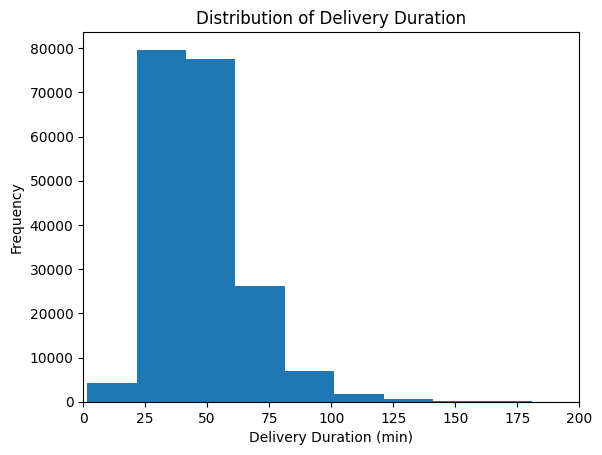

In [ ]:
# histogram of delivery duration
plt.hist(df_copy['delivery_duration_min'], bins=20)
plt.xlabel('Delivery Duration (min)')
plt.ylabel('Frequency')
plt.title('Distribution of Delivery Duration')
plt.xlim(0,200)
plt.show()

Regardless of how we represent this, there is such a vast majority of the data that is in the 25-75 minute area. We can continue to narrow the x axis scale to visualize better

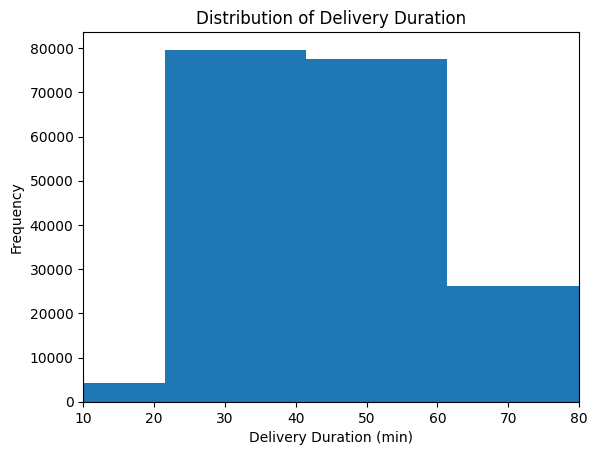

In [ ]:
# histogram of delivery duration w more scale
plt.hist(df_copy['delivery_duration_min'], bins=20)
plt.xlabel('Delivery Duration (min)')
plt.ylabel('Frequency')
plt.title('Distribution of Delivery Duration')
plt.xlim(10,80)
plt.show()

Through this, we can see that there is simply such a high percentage of the data clustered around the 25-60 minute delivery duration. It is important to take this into account for later predictions.

Ultimately, the culmination of our EDA is an extremely vital part to the project. By getting a better grasp on the data and understanding how it is distributed, what potential relations there are, and how they look, we can generate more accurate predictions. However, this in no way tells the entire story of the data, and there are still plenty of hidden relationships and shapes that we cannot see in this alone. That being said, it is a solid foundation for the project.

# Data Cleaning/Preprocessing

In EDA, we noticed that there were some unnatural values (for example, a negative minimum price and negative counts of dashers or outstanding orders). The dataset description tells us that, "We have added noise to the dataset to obfuscate certain business details." As such, we interpret these negative values not as true observations, but as noise injected (rather than meaningful data points). Instead of removing these rows, which could potentially bias our dataset, we decided to clip these values to zero. This ensures that all features remain within reaslitic ranges and we do not reduce our sample size.

In [ ]:
clipped_cols = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'min_item_price']

for col in clipped_cols:
  df[col] = df[col].clip(lower=0)

In [ ]:
# Looking into NAs

df.isna().sum()

,0
market_id,987
created_at,0
actual_delivery_time,7
store_id,0
store_primary_category,4760
order_protocol,995
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


Instead of breaking apart the actual_delivery_time into year/month/etc. and imputing median or mode values, we decided to drop these rows because there were only 7 rows with missing observations and removing such a small number of rows wouldn't significantly impact our data

In [ ]:
df = df.dropna(subset=['actual_delivery_time'])

In [ ]:
df['actual_delivery_time'].isna().sum()

np.int64(0)

Furthermore, we decided to drop store_id and store_primary_category. This variable is prmarily an identifier and doesn't contain meaningful information for our predictive models. Additionally, with over 6,000 unique store IDs, including it would increase dimensionality without adding usable structure to our model

In [ ]:
len(df['store_id'].unique())

6743

We also decided to drop store_primary_category because although it may provide some information about restaurant type, it would require us to create over 75 dummy variables, which would heavily increase the amount of columns our dataset has and risk overfitting. As such, we removed it just for model simplicity

In [ ]:
len(df['store_primary_category'].unique())

75

In [ ]:
df = df.drop(columns=['store_id', 'store_primary_category'])

Additionally, we dropped rows that have NA values for market_id and order_protocol. We do not know the underlying meaning of these IDs, and imputing them (with mode, for example) would bias our dataset towards larger markets for market_id or most common protocol. Since there are only a few rows with NA values, we decided to remove these rows

In [ ]:
df = df.dropna(subset=['market_id', 'order_protocol'])

In [ ]:
df['market_id'].isna().sum()

np.int64(0)

In [ ]:
df['order_protocol'].isna().sum()

np.int64(0)

## One-Hot Encoding Labels

We decided to one-hot encode market_id and order_protocol because these are categorical identifiers, and thus so do not have inherent numeric meaning (market 1 is not "less than" market 2, for example). Encoding them as indicator variables allows our models to appropriately use them as predictors rather than impose an artifical ordering

Before one-hot encoding, we converted these two columns from floats to integers

In [ ]:
cat_cols = ['market_id', 'order_protocol']
for col in cat_cols:
  df[col] = df[col].astype(int)

In [ ]:
df = pd.get_dummies(df, columns=cat_cols, dtype=int)

In [ ]:
df.columns

Index(['created_at', 'actual_delivery_time', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_duration_min',
       'created_hour', 'delivered_hour', 'market_id_1', 'market_id_2',
       'market_id_3', 'market_id_4', 'market_id_5', 'market_id_6',
       'order_protocol_1', 'order_protocol_2', 'order_protocol_3',
       'order_protocol_4', 'order_protocol_5', 'order_protocol_6',
       'order_protocol_7'],
      dtype='object')

## Handling Outliers

We can handle outliers in our dataframes in order to reduce noise and some obvious errors in the dataset (e.g. a delivery taking nearly 16 hours). This ensures it doesn't affect our model and skew the results in any way. We applied the same outlier filtering across all models to keep preprocessing consistent and make our comparisons as fair as possible. We acklowledge that a Random Forest Classifier is relatively robust to outliers and doesn't need them removed, but we figured it would not hurt in this case

Before this, we split our data into our training data and testing data using a stratified 80/20 split to ensure there was no leakage prior to imputation/scaling as well as to mitigate the effect of the class imbalance

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df['delivery_duration_min'].describe()

,delivery_duration_min
count,156740.000000
mean,48.671802
std,359.561767
min,3.720000
25%,35.070000
50%,44.330000
75%,56.320000
max,141947.650000


### Dealing with high outliers

In [ ]:
train_df['delivery_duration_min'].quantile([0.95, .975, .99, .995, .999, .9999])

,delivery_duration_min
0.9500,81.201000
0.9750,92.000000
0.9900,107.720000
0.9950,122.179150
0.9990,168.607830
0.9999,434.700975


We decided to remove any rows that were above the 99.9th percentile because these values are very extreme and are not representative of typical delivery scenarios. While the 99.9th percentile corresponds to a delivery duration of around 169 minutes (which is close to the 99th percentile of 108 minutes), there is a sudden jump to 376 minutes at the 99.99th percentile. As such, by trimming the top 0.1% of observations, this allows us to remove unrealistic outliers while preserving essentially all of our dataset

In [ ]:
q = train_df['delivery_duration_min'].quantile(0.999)

# Apply to both datasets
train_df = train_df[train_df['delivery_duration_min'] <= q].copy()
test_df  = test_df[test_df['delivery_duration_min'] <= q].copy()

We apply the same cutoff to both datasets, ensuring that information from the test distribution does not influence preprocessing decisions

In [ ]:
train_df.shape[0]

156583

In [ ]:
test_df.shape[0]

39162

Overall, we dropped less than 2000 rows, showing that we maintained most of our original data (train and test together give 195,729 rows, and we started with 197,428)

### Dealing with low outliers

In [ ]:
train_df['delivery_duration_min'].quantile([0.001])

,delivery_duration_min
0.001,14.17


In [ ]:
test_df['delivery_duration_min'].quantile([0.001])

,delivery_duration_min
0.001,14.03


Since approximately 14 minutes is reasonable, we decided to not get rid of values on the lower end. We can see from this cleaning as well as our data exploration that the data is heavily right-skewed, which we took into account in our later models

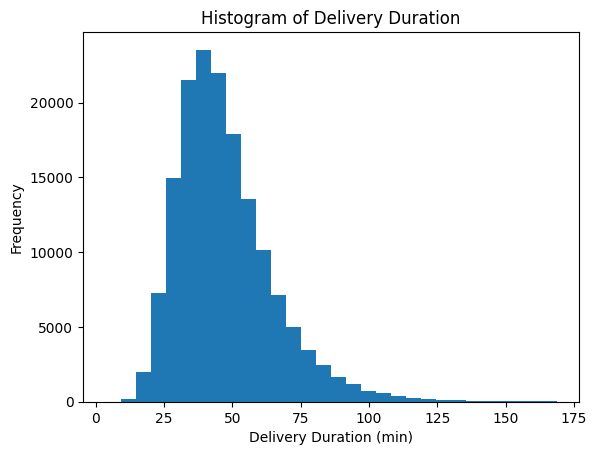

In [ ]:
# code for re-visualization skewness for delivery_duration_min in our training data

plt.hist(train_df['delivery_duration_min'], bins=30)
plt.xlabel('Delivery Duration (min)')
plt.ylabel('Frequency')
plt.title('Histogram of Delivery Duration')
plt.show()

# Response Variable Creation

We also created our response variable for classification. Our response variable is slow_order, which is a delivery whose duration (in minutes) exceeds the 66th percentile of delivery times

In [ ]:
# add column for delivery duration
df['delivery_duration_min'] = ((df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60).round(2)

In [ ]:
# calculate the 66th percentile based off of the training dataset
q66 = train_df["delivery_duration_min"].quantile(0.66)

train_df["slow_order"] = (train_df["delivery_duration_min"] >= q66).astype(int)
test_df["slow_order"]  = (test_df["delivery_duration_min"]  >= q66).astype(int)

In [ ]:
print(q66)

51.18


The 66th percentile threshold was computed on the training split and applied to both train and test to avoid any kind of bias or data leakage

## Further Predictor Creation/Removal

Since created_at and actual_delivery_time are closely related and are datetime objects, we decided to remove them. However, we believe that created_at could give us valuable information, such as hour of the day, and whether or not it was created during the weekend. So, we added these features and removed the actual datetime column. Actual delivery time contains the answer and shouldn't be known during prediction time, so we blatantly removed it

In [ ]:
train_df['created_hour'] = train_df['created_at'].dt.hour
train_df['created_weekend'] = (train_df['created_at'].dt.dayofweek >= 5).astype(int)

test_df['created_hour'] = test_df['created_at'].dt.hour
test_df['created_weekend'] = (test_df['created_at'].dt.dayofweek >= 5).astype(int)

In [ ]:
train_df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)
test_df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

## Correlated Predictors

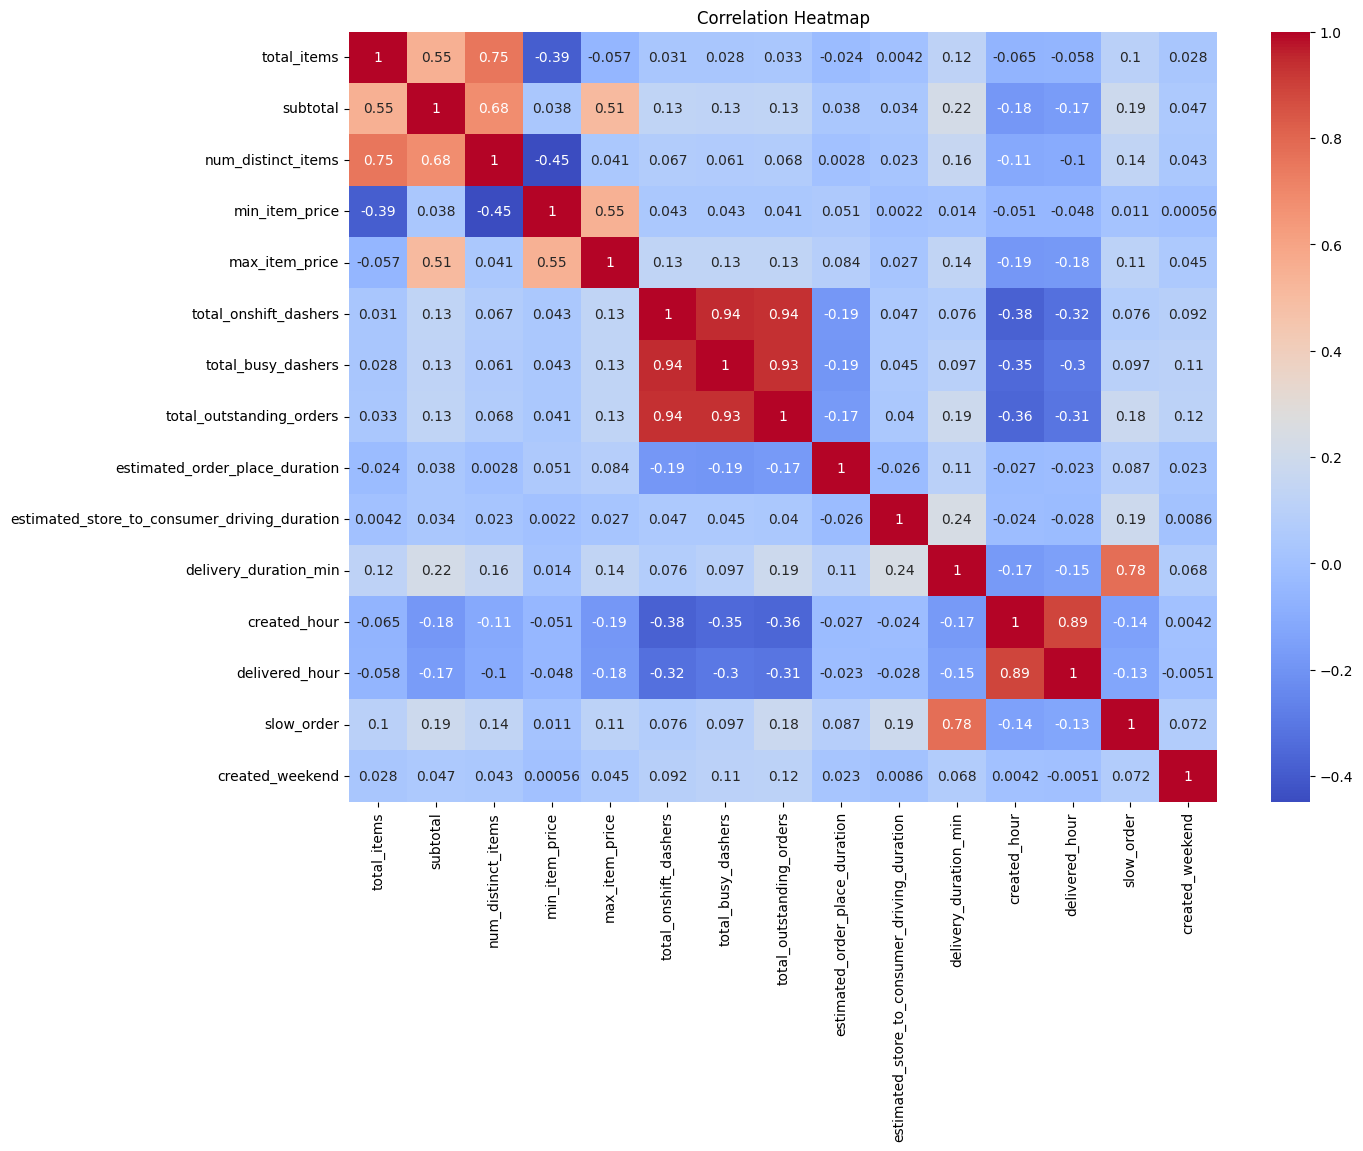

In [ ]:
# creating a heatmap for all predictors except dummy variables
plt.figure(figsize=(14, 10))

dummy_cols = [col for col in train_df.columns if col.startswith('market_id_') or col.startswith('order_protocol_')]

predictor_heatmap_cols = [col for col in train_df.columns if col not in dummy_cols]

sns.heatmap(train_df[predictor_heatmap_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

From here, we can see that total onshift dashers, busy dashers, and outstanding orders are all highly correlated. However, we still chose to keep all three predictors because each captures a distinct aspect of operations (overall driver availability compared to the volume of demand, for example), and altogether influence delivery time

Similarly, although total items and number of distinct items are correlated, one measures how large the order is, whereas the other shows how varied the order is. As such, since this is just a moderate correlation and we do not want to lose predictive power, we decided to keep both predictors in our model as well

However, for binary classification, we will remove delivery_duration_min from the dataset as it gives a direct effect to the response variable. We will only keep it in for linear regression

In [ ]:
train_df.dtypes

,0
total_items,int64
subtotal,int64
num_distinct_items,int64
min_item_price,int64
max_item_price,int64
total_onshift_dashers,float64
total_busy_dashers,float64
total_outstanding_orders,float64
estimated_order_place_duration,int64
estimated_store_to_consumer_driving_duration,float64


We see that some of these objects are floats. However, we want to make them integers, which we do below before further describing the data

In [ ]:
int_cols = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders','estimated_store_to_consumer_driving_duration']

for col in int_cols:
  train_df[col] = train_df[col].astype("Int64") # since some columns till holds NA values, once imputed will become int64
  test_df[col] = test_df[col].astype("Int64")

This is okay to do since all of these columns ('total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders','estimated_store_to_consumer_driving_duration') are all integer-valued floats (e.g. 51.0 or 22.0, always ending in .0). Therefore, no information is lost.

In [ ]:
# making sure all unnecessary floats were converted to integers correctly
train_df.dtypes

,0
total_items,int64
subtotal,int64
num_distinct_items,int64
min_item_price,int64
max_item_price,int64
total_onshift_dashers,Int64
total_busy_dashers,Int64
total_outstanding_orders,Int64
estimated_order_place_duration,int64
estimated_store_to_consumer_driving_duration,Int64


In [ ]:
# making sure all unnecessary floats were converted to integers correctly
test_df.dtypes

,0
total_items,int64
subtotal,int64
num_distinct_items,int64
min_item_price,int64
max_item_price,int64
total_onshift_dashers,Int64
total_busy_dashers,Int64
total_outstanding_orders,Int64
estimated_order_place_duration,int64
estimated_store_to_consumer_driving_duration,Int64


Saving data before our final model - only necessary if there is a need to download the csv files in the block below

In [ ]:
# # will need to uncomment part below to save data to personal device if necessary

# train_df.to_csv("train_df_doordash_pre_imp_scaling.csv", index=False)
# test_df.to_csv("test_df_doordash_pre_imp_scaling.csv", index=False)

# files.download("train_df_doordash_pre_imp_scaling.csv")
# files.download("test_df_doordash_pre_imp_scaling.csv")

# Random Forest Model

In [ ]:
# drop delivery_duration_min because it's correlated with the response variable
train_df = train_df.drop(columns=['delivery_duration_min'])
test_df = test_df.drop(columns=['delivery_duration_min'])

In [ ]:
# split data into features and response variable for both train and test datasets
X_train = train_df.drop(columns=['slow_order'])
y_train = train_df['slow_order']

X_test = test_df.drop(columns=['slow_order'])
y_test = test_df['slow_order']

# Implementing a Random Forest Model

In [ ]:
# Build RF pipeline with median imputation to avoid missing-value issues during CV
rf_pipe = Pipeline([
  ("imputer", SimpleImputer(strategy="median")),
  ("model", RandomForestClassifier(
      random_state=1234,
      class_weight="balanced"
  ))
])

# Hyperparameter search/grid space for tuning the complexity of our model
param_grid = {
  'model__n_estimators': [100, 150, 200],
  'model__max_depth': [12, 16, 20], # Hyperparameter "None" largely overfit - removed since training took ages
  'model__min_samples_split': [10, 20, 50],
  'model__min_samples_leaf': [5, 10, 20],
  'model__max_features': ['sqrt'] # log2 didn't perform as well as sqrt
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

# Randomized hyperparameter search with AUC scoring (helps optimize performance)
random_search = RandomizedSearchCV(rf_pipe, param_distributions=param_grid, n_iter=20, cv=cv, scoring="roc_auc", verbose=1, n_jobs=-1, return_train_score=True,random_state=1234)

random_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation ROC AUC score: {random_search.best_score_:.4f}")

rf = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best hyperparameters found:
{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_features': 'sqrt', 'model__max_depth': 20}

Best cross-validation ROC AUC score: 0.8217


In [ ]:
# hyperparameter tuning / train / validation results

print("Hyperparameter Tuning")
print("Best parameters:", random_search.best_params_)
print("Best CV ROC AUC:", round(random_search.best_score_, 3))

print("\nFinal Model Evaluation with 5-Fold Cross-Validation \n")

final_cv_results = cross_validate(rf, X_train, y_train, cv=cv, scoring=["accuracy", "roc_auc", "f1"], return_train_score=True)

train_acc = final_cv_results["train_accuracy"].mean()
val_acc = final_cv_results["test_accuracy"].mean()

train_auc = final_cv_results["train_roc_auc"].mean()
val_auc = final_cv_results["test_roc_auc"].mean()

train_f1 = final_cv_results["train_f1"].mean()
val_f1 = final_cv_results["test_f1"].mean()

print("Accuracy (train):", round(train_acc, 3))
print("Accuracy (val):", round(val_acc, 3))

print("\nROC AUC (train):", round(train_auc, 3))
print("ROC AUC (val):", round(val_auc, 3))

print("\nF1 (train):", round(train_f1, 3))
print("F1 (val):", round(val_f1, 3))

Hyperparameter Tuning
Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_features': 'sqrt', 'model__max_depth': 20}
Best CV ROC AUC: 0.822

Final Model Evaluation with 5-Fold Cross-Validation 

Accuracy (train): 0.885
Accuracy (val): 0.758

ROC AUC (train): 0.958
ROC AUC (val): 0.822

F1 (train): 0.836
F1 (val): 0.649


In [ ]:
rf.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=1234))])

In [ ]:
# finding probability threshold for highest F1-score

y_train_proba = rf.predict_proba(X_train)[:, 1]
prec, rec, thresh = precision_recall_curve(y_train, y_train_proba)
f1_scores = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 0.00000001) # added 0.00000001 so that it never divides by zero (just in case)
best_idx = np.argmax(f1_scores)
best_threshold = thresh[best_idx]
print("Best F1 threshold on train:", round(best_threshold, 3))
print("Train precision at best threshold:", round(prec[best_idx], 3))
print("Train recall at best threshold:", round(rec[best_idx], 3))

Best F1 threshold on train: 0.503
Train precision at best threshold: 0.808
Train recall at best threshold: 0.853


In [ ]:
# Evaluating test set performance
y_test_proba = rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
test_f1 = f1_score(y_test, y_test_pred)

print("\nRandom Forest Test Performance:\n")
print("Accuracy:", round(test_accuracy, 3))
print("ROC AUC:", round(test_auc, 3))
print("F1 Score:", round(test_f1, 3), "\n")

print("Classification Report:\n")
print(classification_report(y_test, y_test_pred, digits=3))


Random Forest Test Performance:

Accuracy: 0.757
ROC AUC: 0.82
F1 Score: 0.647 

Classification Report:

              precision    recall  f1-score   support

           0      0.814     0.815     0.814     25663
           1      0.647     0.646     0.647     13499

    accuracy                          0.757     39162
   macro avg      0.731     0.730     0.731     39162
weighted avg      0.757     0.757     0.757     39162



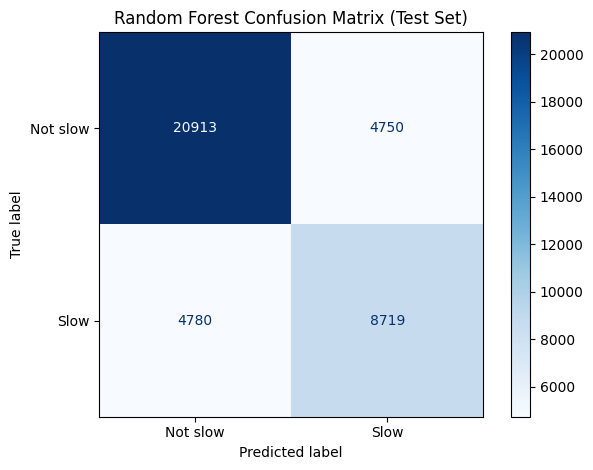

In [ ]:
# confusion matrix
y_test_pred_thresh = (y_test_proba >= best_threshold).astype(int)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred_thresh,
    display_labels=["Not slow", "Slow"],
    cmap='Blues',
    values_format='d'
)
plt.title("Random Forest Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

In [ ]:
# training data
y_train_pred = (y_train_proba >= best_threshold).astype(int)

train_cm = confusion_matrix(y_train, y_train_pred)
TN, FP, FN, TP = train_cm.ravel()

print("\nTraining Confusion Matrix:")
print(pd.DataFrame(train_cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"]))

train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
tpr = TP / (TP + FN)
tnr = TN / (TN + FP)

print("\nTraining Metrics:")
print("Accuracy:", round(train_accuracy, 4))
print("True Positive Rate (Recall):", round(tpr, 4))
print("True Negative Rate:", round(tnr, 4))
print("F1 Score:", round(train_f1, 4))


Training Confusion Matrix:
          Pred 0  Pred 1
Actual 0   92557   10769
Actual 1    7829   45428

Training Metrics:
Accuracy: 0.8812
True Positive Rate (Recall): 0.853
True Negative Rate: 0.8958
F1 Score: 0.8301


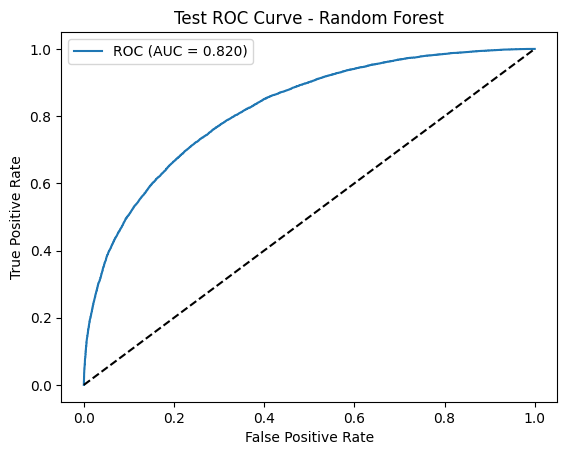

In [ ]:
# Plotting ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr_values, thresholds = roc_curve(y_test, y_test_proba)
auc_value = auc(fpr, tpr_values)

plt.figure()
plt.plot(fpr, tpr_values, label=f"ROC (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve - Random Forest")
plt.legend()
plt.show()

In [ ]:
# visualizing impurity-based feature importances
rf_model = rf.named_steps["model"]

impurity_importance_df = (
  pd.DataFrame({
      "variable": X_train.columns,
      "importance": rf_model.feature_importances_
  })
  .sort_values("importance")
)

print("\nTop Impurity-Based Feature Importances:")
display(impurity_importance_df.tail(20))

px.bar(impurity_importance_df, y="variable", x="importance", orientation="h", title="Impurity-Based Feature Importance", height=600).show()


Top Impurity-Based Feature Importances:


,variable,importance
18,order_protocol_1,0.005981
14,market_id_3,0.006388
20,order_protocol_3,0.006419
22,order_protocol_5,0.006713
15,market_id_4,0.007184
13,market_id_2,0.007773
8,estimated_order_place_duration,0.011316
12,market_id_1,0.014810
25,created_weekend,0.019223
0,total_items,0.023955


In [ ]:
# visualizing permutation impurity-based feature importances

perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0)

perm_importance_df = (
  pd.DataFrame({
      "variable": X_test.columns,
      "importance": perm.importances_mean
  })
  .sort_values("importance")
)

print("\nTop Permutation-Based Feature Importances:")
display(perm_importance_df.tail(20))

px.bar(perm_importance_df, y="variable", x="importance", orientation="h", title="Permutation Importance (Test Set)", height=600).show()


Top Permutation-Based Feature Importances:


,variable,importance
17,market_id_6,0.000125
21,order_protocol_4,0.000143
3,min_item_price,0.000184
23,order_protocol_6,0.000240
15,market_id_4,0.000393
4,max_item_price,0.000500
18,order_protocol_1,0.000521
20,order_protocol_3,0.000753
16,market_id_5,0.000825
14,market_id_3,0.001047


For a deeper analysis of the Random Forest results and discussion, please look to the main report, primarily in sections iii and iv (Methodologies and Results).